In [20]:
# IMPORTING THE LIBRARIES
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler

#(NERI) LIBRARIES USED TO GRAPH
import os
from PIL import Image
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
# THIS TO RUN THE DATASET

def get_train_valid_loader(data_dir,
                               batch_size,
                               augment,
                               random_seed,
                               valid_size=0.1,
                               shuffle=True):
        normalize = transforms.Normalize(
            mean=[0.5551611804640287, 0.491291223366287, 0.44530976833072267],
            std=[0.2700789332643185, 0.254130887428006, 0.25608458818420854],
        )

        # define transforms
        valid_transform = transforms.Compose([
                transforms.Resize((227,227)),
                transforms.ToTensor(),
                normalize,
        ])
        if augment:
            train_transform = transforms.Compose([
                transforms.RandomResizedCrop(227), 
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                normalize,
            ])
        else:
            train_transform = transforms.Compose([
                transforms.Resize((227,227)),
                transforms.ToTensor(),
                normalize,
            ])

        # (NERI) Load the dataset using ImageFolder

        train_dataset = datasets.ImageFolder('dataset/train', transform=train_transform)
        valid_dataset = datasets.ImageFolder('dataset/valid', transform=valid_transform)


        # (NERI) I didnt make this next part
        train_loader = torch.utils.data.DataLoader(
            train_dataset, batch_size=batch_size, shuffle=shuffle) 

        valid_loader = torch.utils.data.DataLoader(
            valid_dataset, batch_size=batch_size, shuffle=False) 

        return (train_loader, valid_loader)


def get_test_loader(data_dir,
                        batch_size,
                        shuffle=True):
        normalize = transforms.Normalize(
            mean=[0.5551611804640287, 0.491291223366287, 0.44530976833072267],
            std=[0.2700789332643185, 0.254130887428006, 0.25608458818420854],
        )

        # define transform
        transform = transforms.Compose([
            transforms.Resize((227,227)),
            transforms.ToTensor(),
            normalize,
        ])
        # (NERI) Load Test Dataset
        test_dataset = datasets.ImageFolder('dataset/test', transform=transform)


        # (NERI) I didnt make this next part
        data_loader = torch.utils.data.DataLoader(
            test_dataset, batch_size=batch_size, shuffle=shuffle
        )

        return data_loader

# Load the datasets
train_loader, valid_loader = get_train_valid_loader(data_dir = './data',batch_size = 64,augment = False,random_seed = 1)

test_loader = get_test_loader(data_dir = './data',
                                  batch_size = 64)

In [22]:
# THE CNN MODEL ITSELF
class AlexNet(nn.Module):
        def __init__(self, num_classes=10):
            super(AlexNet, self).__init__()
            self.layer1 = nn.Sequential(
                nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
                nn.BatchNorm2d(96),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size = 3, stride = 2))
            self.layer2 = nn.Sequential(
                nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
                nn.BatchNorm2d(256),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size = 3, stride = 2))
            self.layer3 = nn.Sequential(
                nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(384),
                nn.ReLU())
            self.layer4 = nn.Sequential(
                nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(384),
                nn.ReLU())
            self.layer5 = nn.Sequential(
                nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(256),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size = 3, stride = 2))
            self.fc = nn.Sequential(
                nn.Dropout(0.5),
                nn.Linear(9216, 4096),
                nn.ReLU())
            self.fc1 = nn.Sequential(
                nn.Dropout(0.5),
                nn.Linear(4096, 4096),
                nn.ReLU())
            self.fc2= nn.Sequential(
                nn.Linear(4096, num_classes))

        def forward(self, x):
            out = self.layer1(x)
            out = self.layer2(out)
            out = self.layer3(out)
            out = self.layer4(out)
            out = self.layer5(out)
            out = out.reshape(out.size(0), -1)
            out = self.fc(out)
            out = self.fc1(out)
            out = self.fc2(out)
            return out

In [23]:
# SETTING THE HYPERPARAMETERS
num_classes = 7
num_epochs = 60
batch_size = 250
learning_rate = 0.01

# (NERI) TO GRAPH THE LOSSES AND CORRECT OUTPUT OF THE CNN
train_losses = []
test_losses = []
train_correct = []
test_correct = []

model = AlexNet(num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)

# Train the model
total_step = len(train_loader)

In [26]:
# TRAINING THE CNN
total_step = len(train_loader)

for epoch in range(num_epochs):
    trn_corr = 0
    epoch_losses = []  # Track this epoch's batches
    for i, (images, labels) in enumerate(train_loader):
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # (NERI) USED TO GET THE LOSS OF EPOCH
        predicted = torch.max(outputs.data, 1)[1]
        batch_corr = (predicted == labels).sum()
        trn_corr += batch_corr

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                       .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
    
    # (NERI) TO TRACK THE LOSS AND CORRECT OF THE CNN
    epoch_losses.append(loss.item())  # Append every batch
    train_losses.append(sum(epoch_losses) / len(epoch_losses))  # Store epoch average
    train_correct.append(trn_corr)

    # Validation
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del images, labels, outputs

        print('Accuracy of the network on the {} validation images: {} %'.format(3500, 100 * correct / total))

Epoch [1/60], Step [39/39], Loss: 1.1111
Accuracy of the network on the 3500 validation images: 26.666666666666668 %
Epoch [2/60], Step [39/39], Loss: 1.8925
Accuracy of the network on the 3500 validation images: 28.333333333333332 %
Epoch [3/60], Step [39/39], Loss: 1.3975
Accuracy of the network on the 3500 validation images: 29.047619047619047 %
Epoch [4/60], Step [39/39], Loss: 0.8728
Accuracy of the network on the 3500 validation images: 31.428571428571427 %
Epoch [5/60], Step [39/39], Loss: 1.1115
Accuracy of the network on the 3500 validation images: 35.476190476190474 %
Epoch [6/60], Step [39/39], Loss: 1.2308
Accuracy of the network on the 3500 validation images: 32.61904761904762 %
Epoch [7/60], Step [39/39], Loss: 0.4909
Accuracy of the network on the 3500 validation images: 29.285714285714285 %
Epoch [8/60], Step [39/39], Loss: 1.0027
Accuracy of the network on the 3500 validation images: 37.61904761904762 %
Epoch [9/60], Step [39/39], Loss: 0.7807
Accuracy of the network o

In [27]:
#TESTING THE CNN
with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            loss = criterion(outputs, labels)
            test_losses.append(loss.item())
            test_correct.append(correct)

            del images, labels, outputs


        print('Accuracy of the network on the {} test images: {} %'.format(3500, 100 * correct / total))




Accuracy of the network on the 3500 test images: 63.80952380952381 %


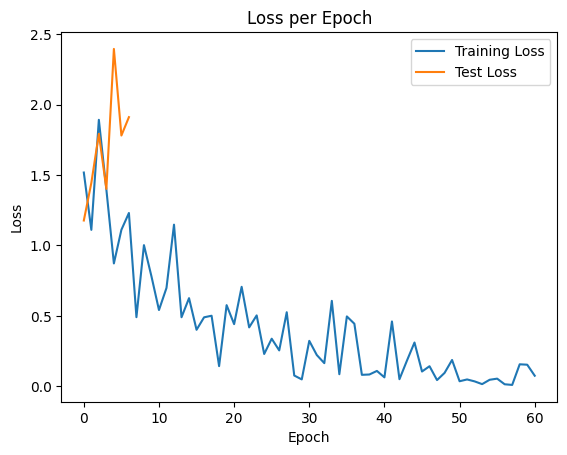

In [28]:
# GRAPH THE LOSS AT EPOCHS
# convert tensors to floats
train_loss_vals = [l.item() if isinstance(l, torch.Tensor) else float(l) for l in train_losses]
test_loss_vals  = [l.item() if isinstance(l, torch.Tensor) else float(l) for l in test_losses]

# Plot directly - already per-epoch
plt.plot(range(len(train_loss_vals)), train_loss_vals, label='Training Loss')
plt.plot(range(len(test_loss_vals)),  test_loss_vals,  label='Test Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


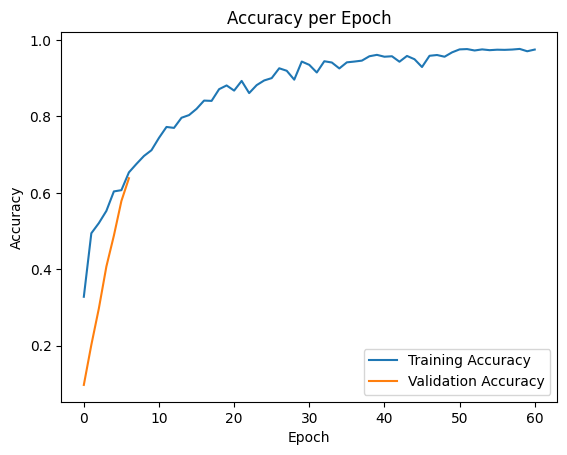

In [29]:
# GRAPH ACCURACY PER EPOCH
# Convert tensors to CPU and then to a list of numbers for plotting
train_correct_cpu = [t.cpu().item() if isinstance(t, torch.Tensor) else t for t in train_correct]
test_correct_cpu = [t.cpu().item() if isinstance(t, torch.Tensor) else t for t in test_correct]

plt.plot([t/2450 for t in train_correct_cpu], label='Training Accuracy') # Use the CPU version for plotting
plt.plot([t/420 for t in test_correct_cpu], label = 'Validation Accuracy') # Use the CPU version for plotting
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show() # Added to display the plot

In [30]:
torch.save(model.state_dict(), 'alexnet_model(State_dict).pth')
torch.save(model, 'alexnet_model(Full model).pth')

In [ ]:
AlexNet = AlexNet(num_classes=7).to(device)
AlexNet.load_state_dict(torch.load('alexnet_model(State_dict).pth'))
AlexNet.eval()  # Set to evaluation mode

AlexNet(
  (layer1): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer4): Sequential(
    (0): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  

In [23]:

# Test function
def test_fn(AlexNet, test_loader):
    total, correct = 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = AlexNet(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

# Run the test
accuracy = test_fn(AlexNet, test_loader)
print(f'Test Accuracy: {accuracy:.2f}')


Test Accuracy: 0.73


In [29]:
normalize = transforms.Normalize(
            mean=[0.1292, -0.1311, -0.1457],
            std=[1.0753, 1.0299, 1.0145],
        )

transform = transforms.Compose([
            transforms.Resize((227,227)),
            transforms.ToTensor(),
            normalize,
])
test_dataset = datasets.ImageFolder('CSV_FILES/test', transform=transform)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=False)

In [31]:
with torch.no_grad():
  correct = 0
  for X_test, y_test in testloader:
    y_val = AlexNet(X_test)
    predicted = torch.max(y_val, 1)[1]
    correct += (predicted == y_test).sum()


In [32]:
correct.item()/len(test_dataset)*100

73.36956521739131

In [61]:
with torch.no_grad():
  new_prediction = AlexNet(test_dataset[150][0].view(1,3,227,227))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.14607507..1.1293248].


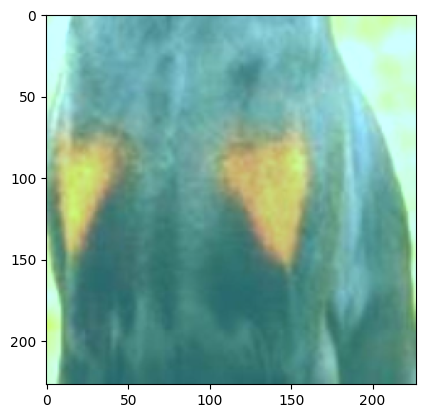

In [62]:
plt.imshow(test_dataset[150][0].permute(1, 2, 0))

In [63]:
# Option A: use the dataset's classes list
class_index = new_prediction.argmax().item()            # convert tensor -> int
class_label = test_dataset.classes[class_index]

print("Predicted class:", class_label)

Predicted class: ringworm
